### 導入套件

cv2：opencv 是計算機視覺，應用於照片識別人臉標示人名


In [12]:
import assignment2.src.constant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import constant  #自訂常量

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

### 處理 Dataset

##### 引入 Dataset

將貓狗`img`轉換成`array`放入`data`中，`label`放入 0、1 分別表示貓和狗
這邊因為我們的資料只有兩種類別，所以不用轉為one-hot code
因為訓練用圖片大小不一，所以 Resize 成同一大小

- 機器學習圖片設為灰階的原因：
  - 減少計算量
  - 很多演算法對於顏色的依賴性不強
  - 識別物體關鍵是梯度，彩色的圖片可能會引響梯度的萃取(ex:光照、陰影等)
  - RGB 不能反映圖像的形態特徵(只是在光學的原理上進行顏色調配)，**顏色所能帶來的信息不多**

> 這裡使用 PIL 讀取圖片會報錯 `UnidentifiedImageError`  
> 發現是 Microsoft 給的資料庫中，PetImages/Cat 和 Dog 資料夾分別有一張 0kB 的假照片  
> 把那兩張照片移除，PIL 便可正常讀取  
> 但這邊還是為了方便，使用 cv2 讀取


In [3]:
import os
import glob
import numpy as np
from PIL import Image

train_dir = os.path.join(constant.DATASET_DIR, 'train')
dict_lables = {"cat": 0, "dog": 1}
size = (64, 64)
data = []
label = []


def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = dict_lables[category]
        img = load_img(os.path.join(path, p), color_mode="grayscale")  # 圖片灰階
        img = img.resize(size, Image.BILINEAR)
        x = img_to_array(img)
        data.append(x)
        label.append(category)


print(train_dir)
create_test_data(train_dir)
data = np.array(data)
label = np.array(label)

C:\Users\USER\Desktop\Master_0\ESC_LAB\assignment2\dataset\train
one-hot "0" will be convert to: [1. 0.]
one-hot "1" will be convert to: [0. 1.]


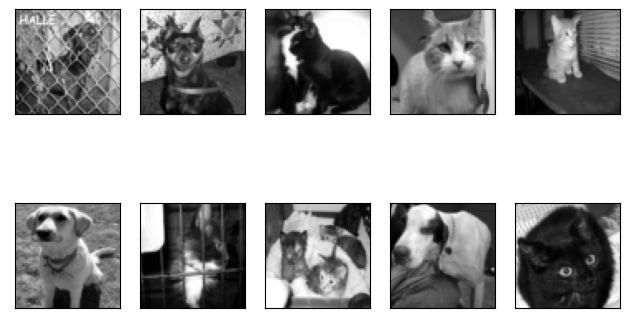

In [6]:
# 顯示部分處理後的圖片
import random

fig = plt.figure()

for i in range(1, 11):
    plt.subplot(2, 5, i)
    im = array_to_img(data[random.randint(0, data.shape[0])])
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

##### 處理圖片

重新定義尺寸和將處理好的陣列儲存，方便下次不用再次處理資料  
資料改變排列順序


In [8]:
import random

print('[Before reshape]:\ndata: {}\nlable:{}'.format(data.shape, label.shape))
data = np.array(data).reshape(-1, 64, 64, 1)
label = np.array(label)
print(f'\n[After Reshape]:\ndata: {data.shape}\nlabel: {label.shape}')

# Normalize Data(資料正規化)
# 我們在進行影像辨識時，我們在進行圖像預處理時，也會習慣將像素值縮放到[0,1]之間(即除以255)
data = data / 255.0

#資料重新排序(洗牌)
temp = list(zip(data, label))
random.shuffle(temp)
data, label = zip(*temp)
# 轉換回去array type
data = np.array(data)
label = np.array(label)

print('...Shuffle whole data and label done.')

# print(data)
# print(label)

# Save array in .npy file in data folder
np.save(os.path.join(constant.DATA_DIR, 'preprocessed_data'), data)
np.save(os.path.join(constant.DATA_DIR, 'preprocessed_label'), label)
print('save preprocessed data done.')

[Before reshape]:
data: (22675, 64, 64, 1)
lable:(22675,)

[After Reshape]:
data: (22675, 64, 64, 1)
label: (22675,)
...Shuffle whole data and label done.
save preprocessed data done.


### 定義建立模型函數

#### 切割資料集

切割為訓練集和測試集資料(8:2)
利用10-fold cross-validation做驗證([參考資料](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md))
[混淆矩陣參考](https://yanwei-liu.medium.com/python%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%AD%86%E8%A8%98-%E5%9B%9B-%E4%BD%BF%E7%94%A8scikit-learn%E9%80%B2%E8%A1%8C%E9%82%8F%E8%BC%AF%E8%BF%B4%E6%AD%B8%E5%88%86%E6%9E%90-a5769715015d)
> 將訓練資料集切成10等分，每次取9:1做訓練和測試
train_test_split() 所接受的變數其實非常單純，基本上為 3 項：『原始的資料』、『Seed』、『比例』
這邊設定訓練資料80%，測試資料20%
* 原始的資料：就如同上方的 data 一般，是我們打算切成 Training data 以及 Test data 的原始資料
* Seed： 亂數種子，可以固定我們切割資料的結果
* 比例：可以設定 train_size 或 test_size，只要設定一邊即可，範圍在 [0-1] 之間

In [ ]:
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold

#load .npy file
data = np.load(os.path.join(constant.DATA_DIR, "preprocessed_data.npy"))
label = np.load(os.path.join(constant.DATA_DIR, "preprocessed_label.npy"))
print('Load preprocessed shuffled data completely.')

#切割訓練資料集和測試資料集8:2
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2, random_state=42)

print("[Shape]:\ntrain data: {}\ntrain label: {}".format(train_data.shape, train_label.shape))
print("\ntest data: {}\ntest data label: {}".format(test_data.shape, test_label.shape))

#切割訓練資料集10等分
KF = KFold(n_splits=10)  #k-cv 10

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

fold_no = 1

for train_index, validation_index in KF.split(data):
    # create model
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=data.shape[1:]))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    # Add a softmax layer with 10 output units:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer="adam",
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    print('\n-------------------------------------------------------------------------')
    print(f'Training for fold: {fold_no}')

    # model fit
    train_data, validation_data = train_index[train_index], train_data[validation_index]
    train_label, validation_label = train_data[train_index], train_data[validation_index]
    history = model.fit(train_data, train_label, epochs=100, validation_data=(validation_data, validation_label),
                        validation_freq=5)

    # save history and model
    os.chdir(constant.OUTPUT_DIR)
    history = pd.DataFrame.from_dict(history.history, orient='index').T
    history.to_excel(f'loss_accuracy_data.xlsx_{fold_no}', sheet_name='sheet1', index=False)
    history.to_pickle(f'loss_accuracy_data_{fold_no}.pkl')
    model.save(f"catdog_model_{fold_no}.h5")

    # Generate evalute:ouput loss and accuracy for each fold
    scores = model.evaluate(test_data, test_label)
    print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    #TODO:prediction: for confusion metric(return y_pred)
    predictions = model.predict(test_data)
    print(classification_report(test_label,predictions))
    model.predict_classes()

    # Increase fold number
    fold_no = fold_no + 1


### 繪製圖表

In [ ]:
import matplotlib.pyplot as plt
import pickle
import os

with open(os.path.join(constant.OUTPUT_DIR, 'loss_accuracy_data.pkl'), 'rb') as file:
    history_data = pickle.load(file)
    history_data = history_data.to_dict(orient='list')


def training_plot(_history):
    loss = _history['loss']
    val_loss = _history['val_loss']
    acc = _history['accuracy']
    val_acc = _history['val_accuracy']

    #製作圖表
    fig = plt.figure(figsize=(8, 8))  #建立畫板(8*4英吋)
    # 描繪損失函數
    fig1 = fig.add_subplot(221)  # 一行兩列的第一個
    fig1.plot(loss, label='train_loss')
    fig1.plot(val_loss, label='val_loss')
    fig1.set_xlabel('Epochs')  #設定x軸
    fig1.set_ylabel('Loss')  #設定y軸
    fig1.set_title('Loss on Training and Validation Data')
    fig1.legend()  #給圖像加圖例
    # plt.show()

    # # subplot acc
    fig2 = fig.add_subplot(222)
    fig2.plot(acc, label='train_acc')
    fig2.plot(val_acc, label='val_acc')
    fig2.set_xlabel('Epochs')
    fig2.set_ylabel('Accuracy')
    fig2.set_title('Accuracy on Training and Validation Data')
    fig2.legend()  #給圖像加圖例

    plt.subplot(223)
    plt.plot(_history['accuracy'])
    plt.plot(_history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  #loc設置圖例位置
    plt.suptitle('img size(64,64), batch_size=32, epoch=10')
    plt.tight_layout()  #自動保持子圖的正確間距


training_plot(history_data)

### 訓練 History 和資料讀檔


In [ ]:
import pandas as pd
import os

os.chdir('C:/Users/USER/Desktop/Master_0/ESC_LAB/assignment2/output')


# 載入pkl檔案
def read_history_pkl():
    train_history = pd.read_pickle("loss_accuracy_data.pkl")
    print(train_history)


read_history_pkl()
# 載入訓練好的模型
model = load_model('catdog_model.h5')
# score = model.evaluate(data, label, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
model.summary()


### 測試模型


In [ ]:
test_dir = os.path.join(os.getcwd(), "dataset", "test1")
test_data = []
id_line = []


def create_test_data(path):
    for f in os.listdir(test_dir):
        id_line.append(f.split(".")[0])
        img = cv2.imread(os.path.join(test_dir, f), cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img, dsize=(80, 80))
        test_data.append(img_arr)


create_test_data(test_dir)
test_data = np.array(test_data).reshape(-1, 80, 80, 1)
test_data = test_data / 255.0

prediction = model.predict(test_data)

In [ ]:
predicted_val = [int(round(p[0])) for p in prediction]
submission_df = pd.DataFrame({'id': id_line, 'label': predicted_val})
submission_df.to_excel("submission.xlsx", sheet_name='sheet1', index=False)
#end------------------------------------------------------------------------------------------------